## Введение в машинное обучение - Проект

## Введение

В рамках данного проекта необходимо обучить модель, которая будет рекомендовать пользователю мобильной сети Мегалайн наиболее подходящий тариф - ультра или смарт. В распоряжении есть датасет, изученный в предыдущем проекте. 

## Загрузка данных

In [113]:
# Импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Загрузим и рассмотрим датасет.

In [114]:
# data = pd.read_csv('/Users/peterefimov/Dropbox/DS_projects/5. Machine Learning. Project./users_behavior.csv')
data = pd.read_csv('/datasets/users_behavior.csv')

display(data.head(10))
print()
print(data.info())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


Нам доступны данные о 3214 пользователях, уже сменивших тариф: количество звонков, суммарное количество потраченных минут, отправленных сообщений и потраченного интернет-трафика, а также выбранный ими тариф. Данные предобработаны, пропущенные значения отсутствуют. Преобразование типов делать не будем, т.к. модели справятся с числами типа float.

#### Вывод по этапу
Данные загружены, рассмотрены, предобработка не требуется.

## Создание выборок

Сперва посмотрим на зависимость признаков друг от друга. 

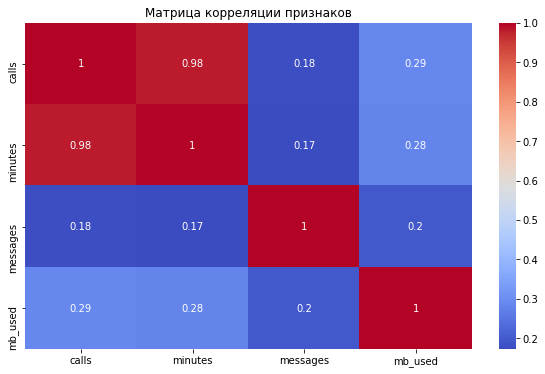

In [115]:
# Рисуем матрицу корреляции, не учитываем признак tariff
plt.figure(figsize=(10,6))
sns.heatmap(data[['calls','minutes','messages','mb_used']].corr(), 
            annot = True, 
            cmap='coolwarm')
plt.title(f'Матрица корреляции признаков')
plt.show()

Обнаружили сильную корреляцию, то есть линейную зависимость, между количеством звонков и потраченных минут. Это можно объяснить тем, что разброс времени условного звонка вероятно невелик, поэтому зависимость линейна. Из теоретического курса знаем, что подобные данные могут помешать обучению некоторых моделей. К тому же, раз зависимость между признаками очевидная, использовать в дальнейшем их оба не обязательно. Поэтому избавимся от признака "количество звонков".

In [116]:
data.drop(['calls'], axis=1, inplace=True)

In [117]:
# Теперь разделим данные на часть с искомым признаком и часть с признаками, 
# по которым будет осуществляться предсказание

x = data.drop(['is_ultra'], axis=1)
y = data['is_ultra']

Теперь разделим данные на три выборки - обучающую, валидационную и тестовую в соотношении 80-10-10, т.к. данных не очень много, и для получения качественной модели обучающую выборку следует сделать покрупнее.

In [118]:
# Сначала отделим 80% обучающей выборки, применим параметр stratify для балансировки выборок
x_train, x_valid_test, y_train, y_valid_test = train_test_split(x, y, 
                                                                test_size=0.2, 
                                                                random_state=12345, 
                                                                stratify=y)

In [119]:
# Теперь разделим оставшийся кусок на валидионную и тестовую сборки

x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test,
                                                    test_size=0.5,
                                                    random_state=12345,
                                                    stratify=y_valid_test)

#### Вывод по этапу
Выявлена сильная линейная зависимость между двумя признаками, один из признаков удалён. Данные разбиты на обучающую, валидационную и тестовую выборки.

## Изучение моделей и подбор гиперпараметров

### Модель Decision Tree

В первую очередь рассмотрим модель решающего дерева. Будем изменять гиперпараметр максимальной глубины дерева. Для этого создадим цикл от 2 до 10 включительно. Подбирать результат будем основываясь на точности модели на обучающей и валидационной выборке.

In [120]:
# Дополнительно укажем гиперпараметр class_weight='balanced'
for depth in range (2,11):
    tree = DecisionTreeClassifier(random_state=12345,
                                  class_weight='balanced',
                                  max_depth=depth)
    tree.fit(x_train, y_train)
    tree_predict = tree.predict(x_valid)
    tree_score_train = tree.score(x_train, y_train)
    tree_score_valid = tree.score(x_valid, y_valid)
    print(f'Для глубины {depth}')
    print(f'Точность модели на обучающей выборке     = {tree_score_train}')
    print(f'Точность модели на валидационной выборке = {tree_score_valid}')
    print()

Для глубины 2
Точность модели на обучающей выборке     = 0.780241151302995
Точность модели на валидационной выборке = 0.7507788161993769

Для глубины 3
Точность модели на обучающей выборке     = 0.793465577596266
Точность модели на валидационной выборке = 0.7757009345794392

Для глубины 4
Точность модели на обучающей выборке     = 0.7572928821470245
Точность модели на валидационной выборке = 0.7445482866043613

Для глубины 5
Точность модели на обучающей выборке     = 0.7619603267211202
Точность модели на валидационной выборке = 0.7414330218068536

Для глубины 6
Точность модели на обучающей выборке     = 0.8218591987553481
Точность модели на валидационной выборке = 0.794392523364486

Для глубины 7
Точность модели на обучающей выборке     = 0.8401400233372228
Точность модели на валидационной выборке = 0.8006230529595015

Для глубины 8
Точность модели на обучающей выборке     = 0.838973162193699
Точность модели на валидационной выборке = 0.794392523364486

Для глубины 9
Точность модели на

Видно, что при макс глубине 8 мы получаем схожий результат по точности на обучающей и валидационной выборке, превосходящий требуемое значение 0.75. Таким образом получаем достаточно точную модель без переобучения. Переобучим модель на заданной глубине и запустим classification_report.

In [121]:
tree = DecisionTreeClassifier(random_state=12345,
                                  class_weight='balanced',
                                  max_depth=8)
tree.fit(x_train, y_train)
tree_predict = tree.predict(x_valid)
tree_score_train = tree.score(x_train, y_train)
tree_score_valid = tree.score(x_valid, y_valid)
print(f'Точность модели на обучающей выборке     = {tree_score_train}')
print(f'Точность модели на валидационной выборке = {tree_score_valid}')
print()
print(classification_report(y_valid, tree_predict))

Точность модели на обучающей выборке     = 0.838973162193699
Точность модели на валидационной выборке = 0.794392523364486

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       223
           1       0.70      0.58      0.63        98

    accuracy                           0.79       321
   macro avg       0.76      0.73      0.75       321
weighted avg       0.79      0.79      0.79       321



Значения выглядят удовлетворительными. Можем проверить результат на тестовой выборке:

In [122]:
score_tree = tree.score(x_test, y_test)
print(f'Точность модели решающего дерева на тестовой выборке {score_tree}')

Точность модели решающего дерева на тестовой выборке 0.7546583850931677


Получили точность выше 0.75. Далее рассмотрим другие изученные модели.

### Модель Random Forest

В случае решающего леса нужно менять одновременно 2 гиперпараметра. Воспользуемся функцией GridSearchCV для подбора оптимальных гиперпараметров для решающего леса.

In [123]:
# Задаём гиперпараметры
param_grid = {'max_depth': [depth for depth in range(5,11)],
             'n_estimators': [10,20,50,100,200]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)

# Задаём более крупные выборки (без тестовой) и обучаем гридсёрч
grid_search.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

Теперь выведем получившиеся оптимальные параметры

In [124]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 100}

Обучим модель решающего леса на полученных гиперпараметрах.

In [125]:
forest = RandomForestClassifier(random_state=12345,
                                  class_weight='balanced',
                                  max_depth=8,
                                    n_estimators=50)
forest.fit(x_train, y_train)
forest_predict = forest.predict(x_valid)
forest_score_train = forest.score(x_train, y_train)
forest_score_valid = forest.score(x_valid, y_valid)
print(f'Точность модели на обучающей выборке     = {forest_score_train}')
print(f'Точность модели на валидационной выборке = {forest_score_valid}')
print()
print(classification_report(y_valid, forest_predict))

Точность модели на обучающей выборке     = 0.8646441073512252
Точность модели на валидационной выборке = 0.8317757009345794

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       223
           1       0.79      0.61      0.69        98

    accuracy                           0.83       321
   macro avg       0.82      0.77      0.79       321
weighted avg       0.83      0.83      0.83       321



Получили хорошие результаты. Проверим обученную модель на тестовой выборке.

In [126]:
score_forest = forest.score(x_test, y_test)
print(f'Точность модели решающего леса на тестовой выборке {score_forest}')

Точность модели решающего леса на тестовой выборке 0.7857142857142857


Получили более высокую точность модели в сравнении с решающим деревом.

### Модель Logistic Regression

Для подбора оптимальных гиперпараметров модели также воспользуемся Гридсёрч.

In [127]:
# В данном случае варьируем параметры пеналти и С
param_grid_LR = {'penalty':['l1','l2','elasticnet','none'],
                'C':[0.1,0.25,0.5,0.75,1.0]}

grid_search_LR = GridSearchCV(LogisticRegression(),param_grid = param_grid_LR)
grid_search_LR.fit(x_train, y_train)

/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/peterefimov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mode

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.25, 0.5, 0.75, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Выведем получившиеся гиперпараметры:

In [128]:
grid_search_LR.best_params_

{'C': 0.1, 'penalty': 'l2'}

Обучим модель логистической регрессии с полученными гиперпараметрах

In [129]:
lr = LogisticRegression(random_state=12345, C=0.1, penalty='l2')
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_valid)
lr_score_train = lr.score(x_train, y_train)
lr_score_valid = lr.score(x_valid, y_valid)
print(f'Точность модели на обучающей выборке     = {lr_score_train}')
print(f'Точность модели на валидационной выборке = {lr_score_valid}')
print()
print(classification_report(y_valid, lr_predict))

Точность модели на обучающей выборке     = 0.7145079735511474
Точность модели на валидационной выборке = 0.7165109034267912

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       223
           1       0.71      0.12      0.21        98

    accuracy                           0.72       321
   macro avg       0.71      0.55      0.52       321
weighted avg       0.71      0.72      0.64       321



In [130]:
score_lr = lr.score(x_test, y_test)
print(f'Точность модели логистической регрессии на тестовой выборке {score_lr}')

Точность модели логистической регрессии на тестовой выборке 0.7018633540372671


Получили наиболее низкую точность в сравнении с двумя предыдущими моделями.

### Выбор оптимальной модели

В результате исследования делаем вывод, что наиболее точный результат на тестовой выборке дала модель решающего леса с гиперпараметрами n_estimators = 50, max_depth = 8. Присвоим эту модель новой переменной:

In [131]:
fine_model = forest
fine_model_test_score = score_forest

## Оценка адекватности модели

Для оценки адекватности полученной модели сравним её результат на тестовой выборке с dummy классификатором.

In [132]:
# Загрузим dummy классификатор
from sklearn.dummy import DummyClassifier

# Присвоим ему стратегию выбора наиболее часто встречающегося класса
dummy_classifier = DummyClassifier(strategy = 'most_frequent')

# Обучим его на обучающей выборке
dummy_classifier.fit(x_train,y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

Проверим получившийся массив предсказаний

In [133]:
dummy_pred = dummy_classifier.predict(x_valid)
display(dummy_pred)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Все значения одинаковы. Сравним его точность с точностью ранее обученной модели решающего леса.

In [134]:
dummy_classifier_score = dummy_classifier.score(x_valid, y_valid)
print(f'Точность dummy классификатора  = {dummy_classifier_score}')
print(f'Точность обученной модели леса = {fine_model_test_score}')

Точность dummy классификатора  = 0.6947040498442367
Точность обученной модели леса = 0.7857142857142857


Точность полученной модели выше точности dummy классификатора. Также точность выше заданного уровня - 0.75. Таким образом, в рамках данного проекта обученную модель решающего леса можно считать удовлетворительной.

## Общий вывод

В рамках проекта были решены задачи:
1. Загружен и изучен датасет.
2. Выявлены и обработаны признаки с выраженной линейной зависимостью.
3. Данные разбиты на обучающую, валидационную и тестовую выборки.
4. Изучены 3 модели - решающее дерево, лес и логистическая регрессия. К ним подобраны оптимальные гиперпараметры, на полученных гиперпараметрах модели обучены, получены значения их точности на тестовых выборках.
5. Определена модель решающего леса как наиболее точная.
6. Модель проверена на адекватность. Достигнут заданный уровень точности модели.